#IMPORTING REQUIRED LIBRARIES

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random
from tqdm import tqdm

import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator


import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam


from keras.applications import VGG19

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score


In [3]:
!ls

drive  sample_data


In [4]:
%cd "drive/MyDrive/spacesense"

/content/drive/MyDrive/spacesense


In [5]:
p="2750/" #path of dataset

In [6]:
labels=os.listdir("2750/")

In [7]:
labels

['HerbaceousVegetation',
 'Residential',
 'River',
 'Highway',
 'Industrial',
 'PermanentCrop',
 'SeaLake',
 'Forest',
 'Pasture',
 'AnnualCrop']

## DATA VISUALIZATION

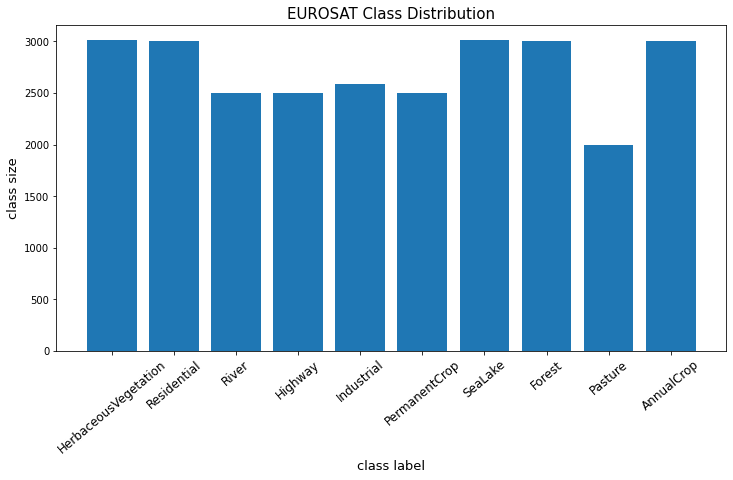

In [8]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(p, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [25]:
TRAIN_DIR = 'training'
TEST_DIR = 'testing'
BATCH_SIZE = 64
NUM_CLASSES=len(labels)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'


#CREATING TRAINING AND TESTING DIRECTORIES

80% training data
20% testing data

In [11]:
# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in labels:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))


'\n# create training and testing directories\nfor path in (TRAIN_DIR, TEST_DIR):\n    if not os.path.exists(path):\n        os.mkdir(path)\n\n# create class label subdirectories in train and test\nfor l in labels:\n    \n    if not os.path.exists(os.path.join(TRAIN_DIR, l)):\n        os.mkdir(os.path.join(TRAIN_DIR, l))\n\n    if not os.path.exists(os.path.join(TEST_DIR, l)):\n        os.mkdir(os.path.join(TEST_DIR, l))\n'

In [12]:
labels

['HerbaceousVegetation',
 'Residential',
 'River',
 'Highway',
 'Industrial',
 'PermanentCrop',
 'SeaLake',
 'Forest',
 'Pasture',
 'AnnualCrop']

In [13]:
# map each image path to their class label in 'data'
data = {}

for l in labels:
    for img in os.listdir(p+"/"+l):
        data.update({os.path.join(p, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('2750/', 'training/', i) for i in train_paths]
    new_test_paths = [re.sub('2750/', 'testing/', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

'# map each image path to their class label in \'data\'\ndata = {}\n\nfor l in labels:\n    for img in os.listdir(p+"/"+l):\n        data.update({os.path.join(p, l, img): l})\n\nX = pd.Series(list(data.keys()))\ny = pd.get_dummies(pd.Series(data.values()))\n\nsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)\n\n# split the list of image paths\nfor train_idx, test_idx in split.split(X, y):\n    \n    train_paths = X[train_idx]\n    test_paths = X[test_idx]\n\n    # define a new path for each image depending on training or testing\n    new_train_paths = [re.sub(\'2750/\', \'training/\', i) for i in train_paths]\n    new_test_paths = [re.sub(\'2750/\', \'testing/\', i) for i in test_paths]\n\n    train_path_map = list((zip(train_paths, new_train_paths)))\n    test_path_map = list((zip(test_paths, new_test_paths)))\n    \n    # move the files\n    print("moving training files..")\n    for i in tqdm(train_path_map):\n        if not os.path.exists(i[1]):\n           

In [26]:
train_gen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=69
)


# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21688 images belonging to 10 classes.
Found 5422 images belonging to 10 classes.


In [16]:
print(train_generator.class_indices)


{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [17]:
np.save('indexed_classes', train_generator.class_indices)


In [75]:
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    

    conv_base = VGG19(include_top=False,
                          weights='imagenet', 
                          input_shape=input_shape)
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    op_model = Dropout(0.2)(top_model)
        
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model





In [ ]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();


In [ ]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat


In [ ]:
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    


In [20]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='weights/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')


In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


##MODEL SUMMARY

In [28]:
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)


vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

#MODEL TRAINING

In [29]:
# re-train whole network end2end 
train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit_generator(train_generator,
                             epochs=100,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             )

<ipython-input-29-782fd90454f0>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg19_history = vgg19_model.fit_generator(train_generator,


Epoch 1/100
339/339 [==============================] - ETA: 0s - loss: 0.6098 - categorical_accuracy: 0.7896 
Epoch 1: val_categorical_accuracy improved from -inf to 0.91092, saving model to weights/model.weights.best.hdf5
339/339 [==============================] - 11110s 33s/step - loss: 0.6098 - categorical_accuracy: 0.7896 - val_loss: 0.2629 - val_categorical_accuracy: 0.9109
Epoch 2/100
339/339 [==============================] - ETA: 0s - loss: 0.2666 - categorical_accuracy: 0.9157
Epoch 2: val_categorical_accuracy improved from 0.91092 to 0.92420, saving model to weights/model.weights.best.hdf5
339/339 [==============================] - 55s 162ms/step - loss: 0.2666 - categorical_accuracy: 0.9157 - val_loss: 0.2473 - val_categorical_accuracy: 0.9242
Epoch 3/100
339/339 [==============================] - ETA: 0s - loss: 0.1700 - categorical_accuracy: 0.9461
Epoch 3: val_categorical_accuracy improved from 0.92420 to 0.95592, saving model to weights/model.weights.best.hdf5
339/339 [=

#MODEL ACCURACY AND LOSS STATS

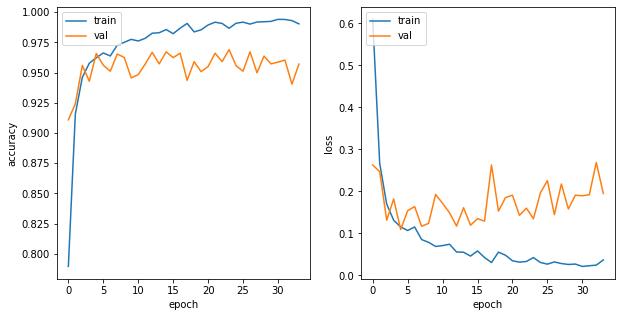

In [38]:
plot_history(vgg19_history)

##SAVE MODEL

In [41]:
vgg19_model.save('models/vgg1.h5')